## 리뷰 데이터 LSTM(+Word Embedding)을 활용해 모델링 
----

- [캐글 커널 Reference](https://www.kaggle.com/alexcherniuk/imdb-review-word2vec-bilstm-99-acc)

In [21]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec, Phrases

# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

### Set some matplotlib configs for visualization

----

- 시각화의 크기 default 값 설정

In [22]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

In [23]:
train_data = pd.read_csv('./data/total_data_11_27.csv', encoding='utf-8-sig')


print(train_data.info)
train_data.head()

<bound method DataFrame.info of                                                   review  score
0      마퍼디였을 때도 맛있었는데 껠끄쇼즈 최근 2번 방문했어요! 역시 실망시키지 않는 곳...      1
1      쫀맛탱..! 비싸지만 진짜진짜 그 값 하는 디저트였어요.\n레몬타르트였나 패션후르츠...      1
2      9월 12일까지 현재 주소와 이름으로 운영하고, 이후 18일부터 새로운 이름 껠끄쇼...      1
3                                            대치동 최애 디저트집      1
4      시그니쳐인 바닐라 타르트를 먹어봤다 당도도\n적당했고 크기는 작은편이지만 정말 맛있...      0
5      클라시크와 몽블랑!\n사실 다녀온지는 좀 됐지만 이제서야 남기는리뷰ㅠ ㅡㅠ\n\n몽...      1
6                                    까눌레가 맛있고 마카롱은 그냥그래요      0
7      레몬유자패션타르트를 먹었는데 아주 새콤달콤하니 맛있었요. 마카롱도 먹었는데 사진은 ...      1
8      르 데흐니에, 유자 패션푸르트 타르트, 파리 브레스트, 잔뒤야 프랄리네 소금 마카롱...      1
9      12시30분 오픈인데 28분인가 도착했더니 이미 앞엔 여섯팀? 정도 대기 중.. 그...      1
10     스테디셀러인 말차헤이즐넛과 바닐라는 맨날 늦어서 못 먹은지 어언 이년이 다되어가는데...      1
11     맜있어요! 하지만 꼬끄쫀득파로써 기대가 너무 컸던 탓인지 엄청 맛있다까지는 잘 모르...      1
12     일단 들어가자마자 받은 느낌은 굉장히 아기자기하다?? ㅎㅎㅎ 입구도 크지않고 내부도...      1
13                                                ♡합니당..      1
14     대

,review,score
0,마퍼디였을 때도 맛있었는데 껠끄쇼즈 최근 2번 방문했어요! 역시 실망시키지 않는 곳...,1
1,쫀맛탱..! 비싸지만 진짜진짜 그 값 하는 디저트였어요.\n레몬타르트였나 패션후르츠...,1
2,"9월 12일까지 현재 주소와 이름으로 운영하고, 이후 18일부터 새로운 이름 껠끄쇼...",1
3,대치동 최애 디저트집,1
4,시그니쳐인 바닐라 타르트를 먹어봤다 당도도\n적당했고 크기는 작은편이지만 정말 맛있...,0


#### WordEmbedding model은 data imbalanced 처리할 필요 x
----

### Transfer numpy data type
---


- pandas을 그대로 사용할 경우 속도가 매우 느려지기 때문에, numpy자료형로 변환해 사용
+ Pure python list 자료형보다 numpy array가 더욱 빠름

In [24]:
all_reviews = np.array([], dtype=str)
all_reviews = np.concatenate((all_reviews, train_data.review), axis=0)
print('Total number of reviews:', len(all_reviews))

Total number of reviews: 92816


In [25]:
all_reviews = train_data.drop(['score'], axis=1)

all_reviews.head()

,review
0,마퍼디였을 때도 맛있었는데 껠끄쇼즈 최근 2번 방문했어요! 역시 실망시키지 않는 곳...
1,쫀맛탱..! 비싸지만 진짜진짜 그 값 하는 디저트였어요.\n레몬타르트였나 패션후르츠...
2,"9월 12일까지 현재 주소와 이름으로 운영하고, 이후 18일부터 새로운 이름 껠끄쇼..."
3,대치동 최애 디저트집
4,시그니쳐인 바닐라 타르트를 먹어봤다 당도도\n적당했고 크기는 작은편이지만 정말 맛있...


In [26]:
from Word2VecUtility import Word2VecUtility

all_reviews = np.array(Word2VecUtility.apply_by_multiprocessing(all_reviews['review'], Word2VecUtility.review_to_wordlist, workers=4))

In [27]:
train_x = all_reviews
train_y = train_data.score.values

In [28]:
train_y = train_data.score.values

In [29]:
print(type(train_x))
print(type(train_y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### See review length distribution
----


- input length를 결정하기 위해 각 리뷰들의 단어 길이에 대한 분포를 살펴봄.

In [31]:
train_data['review_length'] = np.array(list(map(len, train_x)))


median = train_data['review_length'].median()
mean = train_data['review_length'].mean()
mode = train_data['review_length'].mode()[0]

In [32]:
max(train_data['review_length'])

1861

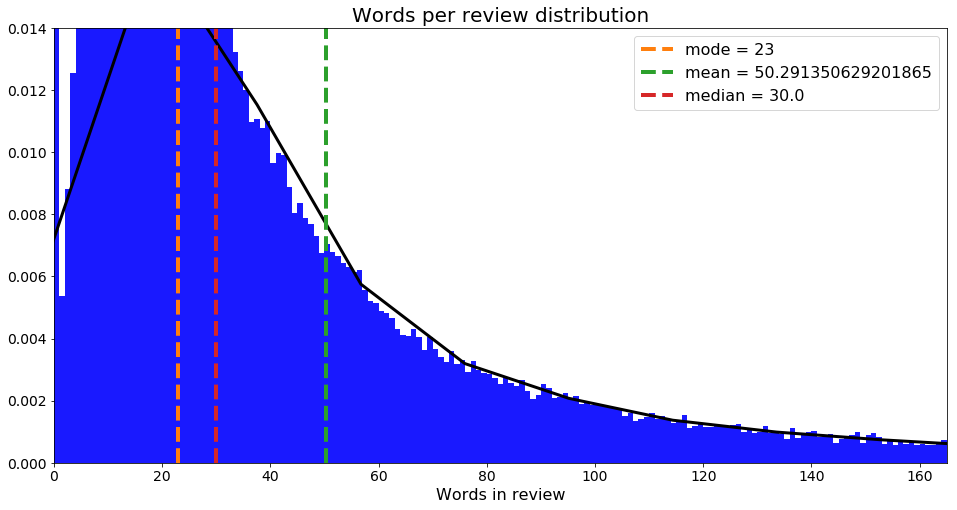

In [33]:
fig, ax = plt.subplots()
sb.distplot(train_data['review_length'], bins=train_data['review_length'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(train_data['review_length'], 95))
ax.set_xlabel('Words in review')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label='mode = {}'.format(mode), linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label='mean = {}'.format(mean), linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label='median = {}'.format(median), linewidth=4)
ax.set_title('Words per review distribution', fontsize=20)
plt.legend()
plt.show()

#### Box plot 만들어서 이상치에 대한 분포 확인하기.

## N-gram 모델
---

- [참고 사이트](https://wikidocs.net/21692)

In [34]:
%%time
bigrams = Phrases(sentences=all_reviews)

CPU times: user 5.79 s, sys: 48 ms, total: 5.84 s
Wall time: 5.84 s


In [35]:
%%time
trigrams = Phrases(sentences=bigrams[all_reviews])

CPU times: user 20 s, sys: 51.9 ms, total: 20.1 s
Wall time: 20.1 s


In [36]:
print(bigrams['space station near the solar system'.split()])

['space', 'station', 'near', 'the', 'solar', 'system']


In [37]:
%%time
embedding_vector_size = 500
trigrams_model = Word2Vec(
    sentences = trigrams[bigrams[all_reviews]],
    size = embedding_vector_size,
    min_count=40, window=5, workers=4)

CPU times: user 3min 29s, sys: 142 ms, total: 3min 29s
Wall time: 2min 58s


In [38]:
print("Vocabulary size:", len(trigrams_model.wv.vocab))

Vocabulary size: 6968


In [39]:
trigrams_model.wv.most_similar("버거")

[('타코', 0.7716417908668518),
 ('햄버거', 0.7589826583862305),
 ('아보카도_버거', 0.6708163619041443),
 ('치킨_버거', 0.6700154542922974),
 ('돈까스', 0.6674783229827881),
 ('군_만두', 0.6623967885971069),
 ('프라이', 0.6606208086013794),
 ('피자', 0.6603155136108398),
 ('파니니', 0.6582499146461487),
 ('크림_마효', 0.6500504016876221)]

In [40]:
trigrams_model.wv.doesnt_match(['콜라', '버거', '감자', '치즈'])

'콜라'

In [41]:
trigrams_model.save('./trigrams.model')

#### Check Input length to decide pad sequences size 
---

- 위에 word 분포 길이에 근거 해서 pad_sequences size 결정하기

In [42]:
%%time
def vectorize_data(data, vocab: dict) -> list:
    print('Vectorize sentences...', end='\r')
    keys = list(vocab.keys())
    filter_unknown = lambda word: vocab.get(word, None) is not None
    encode = lambda review: list(map(keys.index, filter(filter_unknown, review)))
    vectorized = list(map(encode, data))
    print('Vectorize sentences... (done)')
    return vectorized

print('Convert sentences to sentences with ngrams...', end='\r')
X_data = trigrams[bigrams[train_x]]
print('Convert sentences to sentences with ngrams... (done)')
input_length = 200 # 리뷰 데이터 단어들 분포에 맞게 적절한 값 설정.
X_pad = pad_sequences(
    sequences=vectorize_data(X_data, vocab=trigrams_model.wv.vocab),
    maxlen=input_length,
    padding='post')
print('Transform sentences to sequences... (done)')

Convert sentences to sentences with ngrams... (done)
Vectorize sentences... (done)
Transform sentences to sequences... (done)
CPU times: user 3min 14s, sys: 171 ms, total: 3min 14s
Wall time: 3min 14s


In [43]:
X_pad[0]

array([5074, 1476, 4052,  404, 2790, 6179, 2220, 1304, 6603,  424, 4161,
       6692,   92, 6896, 1762, 2853, 4868,  909, 6658, 4052, 6606,  404,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [47]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np



def down_sampling(df, target_label):
    """ Random Under Sampling.

    Solve data imbalanced.
    :param df: data frame
    :return: down sampling data frame.
    """
    rus = RandomUnderSampler(return_indices=True)
    print("Data label imbalanced percentage 1 : {} 0 : {}",
          len(df[df[target_label] == 1]) / len(df), len(df[df[target_label] == 0]) / len(df))

    X_tl, y_tl, id_tl = rus.fit_sample(df, df[target_label])

    # remake data frame.
    columns = df.columns
    df = pd.DataFrame(X_tl, columns=columns)
    # df = df.astype(float)

    return df

In [48]:
train_x = pd.DataFrame(X_pad)
train_x['score'] = train_y

In [49]:
train_x.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,score
0,5074,1476,4052,404,2790,6179,2220,1304,6603,424,...,0,0,0,0,0,0,0,0,0,1
1,469,2785,1835,6442,1304,6658,6570,3812,6570,2770,...,0,0,0,0,0,0,0,0,0,1
2,912,3755,3724,4729,6687,5402,6106,3960,6710,4753,...,0,0,0,0,0,0,0,0,0,1
3,512,1219,6658,1165,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3611,406,3219,886,5318,5795,1476,3432,599,4828,...,5912,858,5011,3724,6211,3611,4725,6159,3577,0


In [50]:
len(train_x)

92816

In [51]:
samplig_train_x = down_sampling(train_x, 'score')

Data label imbalanced percentage 1 : {} 0 : {} 0.8899112222030684 0.11008877779693156


In [52]:
samplig_train_x.head()

train_x = samplig_train_x.drop(['score'], axis=1)
train_y = samplig_train_x['score']

In [53]:
print(train_x.shape)
print(train_y.shape)

(20436, 200)
(20436,)


### split train, validation, test set
----

In [54]:
from sklearn.model_selection import train_test_split

train_x, validaion_x, train_y, validaion_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)

In [55]:
print(train_x.shape)
print(train_y.shape)

(16552, 200)
(16552,)


## Save DataSet
---

In [56]:
DEFAULT_PATH = './'
DATA_IN_PATH = 'data_in/'

TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'

VALIDATION_INPUT_DATA = 'nsmc_validation_input.npy'
VALIDATION_LABEL_DATA = 'nsmc_validation_label.npy'

TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'


import os

if not os.path.exists(DEFAULT_PATH + DATA_IN_PATH):
    os.makedirs(DEFAULT_PATH + DATA_IN_PATH)
    
np.save(open(DEFAULT_PATH + DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_x)
np.save(open(DEFAULT_PATH + DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_y)

np.save(open(DEFAULT_PATH + DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_x)
np.save(open(DEFAULT_PATH + DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_y)

np.save(open(DEFAULT_PATH + DATA_IN_PATH + VALIDATION_INPUT_DATA, 'wb'), validaion_x)
np.save(open(DEFAULT_PATH + DATA_IN_PATH + VALIDATION_LABEL_DATA, 'wb'), validaion_y)


In [57]:
import numpy as np

DEFAULT_PATH = './'
DATA_IN_PATH = 'data_in/'

TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'

VALIDATION_INPUT_DATA = 'nsmc_validation_input.npy'
VALIDATION_LABEL_DATA = 'nsmc_validation_label.npy'

TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'


import os

if not os.path.exists(DEFAULT_PATH + DATA_IN_PATH):
    os.makedirs(DEFAULT_PATH + DATA_IN_PATH)
    
TRAIN_X = np.load(open(DEFAULT_PATH + DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
TRAIN_Y = np.load(open(DEFAULT_PATH + DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))

TEST_X = np.load(open(DEFAULT_PATH + DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
TEST_Y = np.load(open(DEFAULT_PATH + DATA_IN_PATH + TEST_LABEL_DATA, 'rb'))

VALIDATION_X = np.load(open(DEFAULT_PATH + DATA_IN_PATH + VALIDATION_INPUT_DATA, 'rb'))
VALIDATION_Y = np.load(open(DEFAULT_PATH + DATA_IN_PATH + VALIDATION_LABEL_DATA, 'rb'))


In [58]:
print(len(TRAIN_X), len(TRAIN_Y))
print(len(TEST_X), len(TEST_Y))
print(len(VALIDATION_X), len(VALIDATION_Y))

16552 16552
1840 1840
2044 2044


In [59]:
len(train_y)

16552

In [60]:
def build_model(embedding_matrix: np.ndarray, input_length: int):
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(Bidirectional(LSTM(128, recurrent_dropout=0.1)))
    model.add(Dropout(0.25))
    model.add(Dense(64))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=trigrams_model.wv.vectors,
    input_length=input_length)

W1210 22:44:00.179534 139722838202112 deprecation_wrapper.py:119] From /home/skeks463/projects/venv/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1210 22:44:00.188846 139722838202112 deprecation_wrapper.py:119] From /home/skeks463/projects/venv/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1210 22:44:00.190311 139722838202112 deprecation_wrapper.py:119] From /home/skeks463/projects/venv/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1210 22:44:00.196071 139722838202112 deprecation_wrapper.py:119] From /home/skeks463/projects/venv/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 500)          3484000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               644096    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,144,609
Trainable params: 660,609
Non-trainable params: 3,484,000
______________________________________

### RNN 모델링
---

In [61]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history = model.fit(
    x=TRAIN_X,
    y=TRAIN_Y,
    validation_data=(VALIDATION_X, VALIDATION_Y),
    batch_size=100,
    epochs=20)



W1210 22:44:03.458988 139722838202112 deprecation_wrapper.py:119] From /home/skeks463/projects/venv/lib/python3.5/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1210 22:44:03.474688 139722838202112 deprecation.py:323] From /home/skeks463/projects/venv/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16552 samples, validate on 2044 samples
Epoch 1/20
16552/16552 [==============================] - 68s 4ms/step - loss: 0.6931 - acc: 0.5534 - val_loss: 0.6773 - val_acc: 0.5700
Epoch 2/20
16552/16552 [==============================] - 67s 4ms/step - loss: 0.6515 - acc: 0.6178 - val_loss: 0.6484 - val_acc: 0.6155
Epoch 3/20
16552/16552 [==============================] - 67s 4ms/step - loss: 0.6286 - acc: 0.6437 - val_loss: 0.6361 - val_acc: 0.6262
Epoch 4/20
16552/16552 [==============================] - 67s 4ms/step - loss: 0.6062 - acc: 0.6696 - val_loss: 0.6281 - val_acc: 0.6453
Epoch 5/20
16552/16552 [==============================] - 67s 4ms/step - loss: 0.5876 - acc: 0.6811 - val_loss: 0.6389 - val_acc: 0.6409
Epoch 6/20
16552/16552 [==============================] - 67s 4ms/step - loss: 0.5695 - acc: 0.6979 - val_loss: 0.6417 - val_acc: 0.6341
Epoch 7/20
16552/16552 [==============================] - 68s 4ms/step - loss: 0.5497 - acc: 0.7141 - val_loss: 0.6200 - val_acc:

In [63]:
%%time
y_train_pred = model.predict_classes(TRAIN_X)
y_test_pred = model.predict_classes(TEST_X)

CPU times: user 3min 34s, sys: 5.63 s, total: 3min 40s
Wall time: 30 s


In [64]:
pred_y_train = np.array([str(x[0]) for x in y_train_pred])
pred_y_test = np.array([str(x[0]) for x in y_test_pred])

type(pred_y_train)

numpy.ndarray

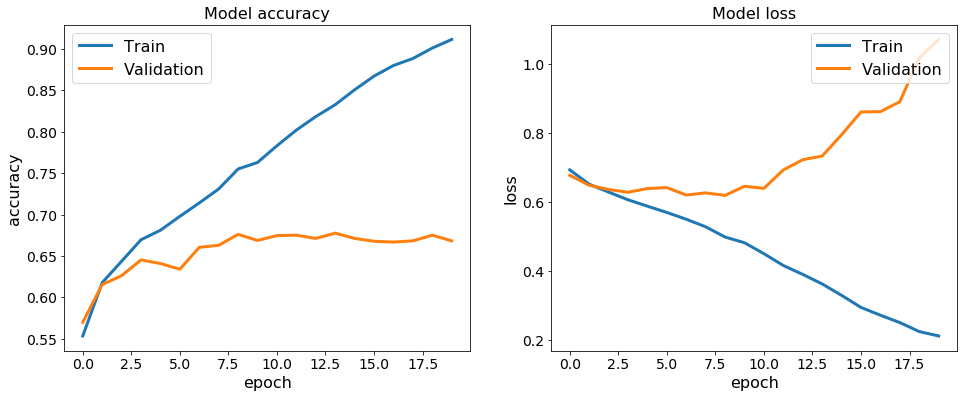

In [65]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# Accuracy Histroy
axis1.plot(history.history['acc'], label='Train', linewidth=3)
axis1.plot(history.history['val_acc'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# Loss Histroy
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()